In [56]:
%load_ext autoreload
%autoreload

import pandas as pd
from vis import draw
from py2neo import Graph
from py2neo import Node
from py2neo import Relationship
from helper import convert_nmap_xml, convert_subdomain
import plotly.express as px
from IPython.display import display, HTML

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preprocess Data

In [49]:
nmap_df = convert_nmap_xml("data/nmap.xml")
nmap_df.head()

,address,port,state,reason,reason_ttl,servicename,serviceproduct,serviceversion,serviceinfo,serviceconf
0,139.11.5.11,53,open,syn-ack,58,domain,PowerDNS,None,None,10
1,139.11.5.12,53,open,syn-ack,58,domain,PowerDNS,None,None,10
2,139.11.5.13,53,open,syn-ack,58,domain,PowerDNS,None,None,10
3,139.11.5.22,25,open,syn-ack,58,nagios-nsca,Nagios NSCA,None,None,10
4,139.11.5.22,465,open,syn-ack,58,ssl,None,None,None,10


In [50]:
nmap_df.shape

(190, 10)

In [51]:
nmap_df["count"] = 1

In [52]:
nmap_df["port"] = nmap_df["port"].astype("str")

In [53]:
nmap_df.fillna("unknown", inplace=True)

# Diagram Servicename and Serviceproduct

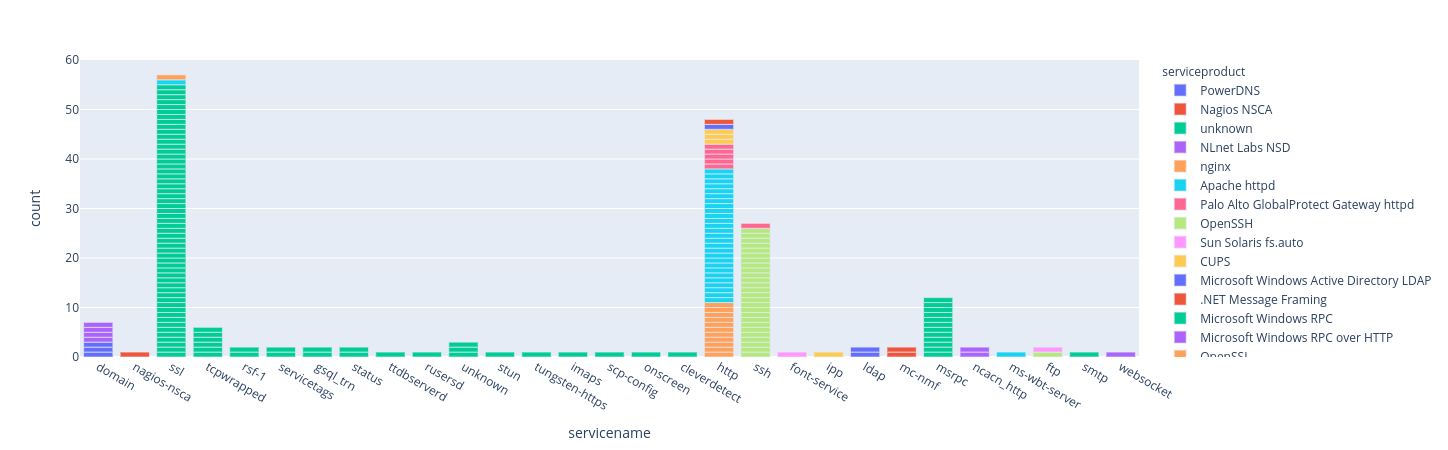

In [57]:
fig = px.bar(nmap_df, x='servicename', y='count', color ='serviceproduct')
fig.show()

# Graph Visualisierung Services und IPs

In [58]:
graph = Graph("http://172.17.0.1:7474/", password="start123")
graph.delete_all()

In [59]:
graph.delete_all()
ip_dict = {}
domain_dict = {}
param = "servicename"

for index, row in nmap_df.iterrows():
    node = Node("Host", 
                name=row["address"],
                description=f"Host<br>{row['address']}",
                color="lime")
    graph.create(node)
    domain_dict[row["address"]] = node
    
    if row[param] not in domain_dict.keys():
        node = Node(param, 
                    name=row[param],
                    description=f"param<br>{row[param]}",
                    color="lime")
        graph.create(node)
        domain_dict[row[param]] = node


for index, row in nmap_df.iterrows():
    graph.create(Relationship(domain_dict[row["address"]], 
                              "belongs_to",
                              domain_dict[row[param]]))

In [60]:
output = draw(graph, physics=True, physics_model="forcedAtlas2Based")
output[0][0]

In [61]:
display(HTML(f'<a href={output[0][1]}> Click to download graph</a>'))

# Graph Visualisierung Services, IPs und Subdomains

In [62]:
subdomain_df = convert_subdomain("data/all_subdomains_hsu-hh.de.txt")
subdomain_df.head()

,domainname,ips
0,autodiscover.hsu-hh.de,139.11.9.20
1,autoconfig.hsu-hh.de,139.11.6.20
2,fueak.hsu-hh.de,139.11.81.160
3,meetings.hsu-hh.de,139.11.11.50
4,campus.hsu-hh.de,139.11.9.55


In [63]:
graph.delete_all()
domain_dict = {}
param = "servicename"

for index, row in subdomain_df.iterrows():
    node = Node("Host", 
                name=row["domainname"],
                description="Webserver",
                color="lime")
    graph.create(node)
    domain_dict[row["domainname"]] = node
   
       
    if row['ips'] not in domain_dict.keys():
        node = Node("IP", 
                    name=row['ips'], 
                    description="IP Address",
                    color="blue")
        graph.create(node)
        domain_dict[row["ips"]] = node
        
for index, row in nmap_df.iterrows():
    if row["address"] not in domain_dict.keys():
        node = Node("IP", 
                    name=row["address"],
                    description=f"Host<br>{row['address']}",
                    color="lime")
        graph.create(node)
        domain_dict[row["address"]] = node
    
    if row[param] not in domain_dict.keys():
        node = Node(param, 
                    name=row[param],
                    description=f"param<br>{row[param]}",
                    color="lime")
        graph.create(node)
        domain_dict[row[param]] = node
        

        
for index, row in subdomain_df.iterrows():
    graph.create(Relationship(domain_dict[row["domainname"]], 
                              "belongs_to",
                              domain_dict[row["ips"]]))
    
for index, row in nmap_df.iterrows():
    graph.create(Relationship(domain_dict[row["address"]], 
                              "belongs_to",
                              domain_dict[row[param]]))

In [64]:
output = draw(graph, physics=True, physics_model="forcedAtlas2Based")
output[0][0]

In [65]:
display(HTML(f'<a href={output[0][1]}> Click to download graph</a>'))